# Technical Analysis of Tesla using Machine Learning
You will be able to do technical analysis for any stock with this notebook, just change the source of CSV file. I downloaded TSLA stock data from yahoo finance, as long as you use Yahoo finance you shouldn't need to change anything in notebook 

Source  https://finance.yahoo.com/quote/TSLA/history?period1=1262322000&period2=1557288000&interval=1d&filter=history&frequency=1d

Author : Kshitiz Sharma

## 1) Exploratory Data Analysis(EDA)

In [53]:
# Importing basic python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-04  230.720001  231.380005  219.000000  223.410004  223.410004   
2016-01-05  226.360001  226.889999  220.000000  223.429993  223.429993   
2016-01-06  220.000000  220.050003  215.979996  219.039993  219.039993   
2016-01-07  214.190002  218.440002  213.669998  215.649994  215.649994   
2016-01-08  217.860001  220.440002  210.770004  211.000000  211.000000   

             Volume  
Date                 
2016-01-04  6827100  
2016-01-05  3186800  
2016-01-06  3779100  
2016-01-07  3554300  
2016-01-08  3628100  




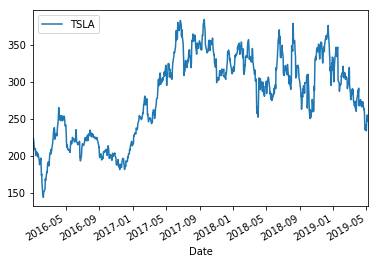

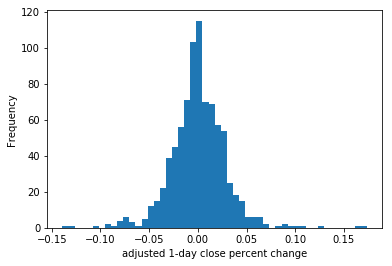

In [54]:
# Loading the source, enter the ticker and change source of csv file 
ticker='TSLA'
data=pd.read_csv("TSLA.csv")

# Chaning the Date to index
data.index=data['Date']
data=data.drop('Date',axis=1)
data.index=pd.to_datetime(data.index)

data=data[data.index>'2016']

print(data.head(5))
print("\n")

# Plotting the Adj Close for the stock 
data['Adj Close'].plot(label=ticker, legend=True)
plt.show()

data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted 1-day close percent change')
plt.show()

Takeaways for TSLA stock<br>
1) The stock above shows 3 cycels between 2010 to 2013, 2013 to Mid 2017 and Mid 2017 to today, they are like 3 different life cycles<br>
2) The daily % change is normally distributed, so we can go ahead

## 2) Correlations

Pearson's correlation. Create a 5 days changes of Adj Close for current day, and 5 days in the future. <br>

In simple words I am comparing Corrlation between ((T+5)-(T)) Returns & ((T+10)-(T+5)) Returns to see if the stock has a mean reverting process or trend following


                5DCloseFuture%  5DClose%
5DCloseFuture%        1.000000 -0.021397
5DClose%             -0.021397  1.000000


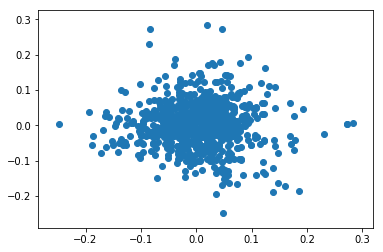

In [55]:
data['5DayFutureClose']=data['Adj Close'].shift(-5)
data['5DCloseFuture%']=data['5DayFutureClose'].pct_change(5)
data['5DClose%']=data['Adj Close'].pct_change(5)

corr=data[['5DCloseFuture%','5DClose%']].corr()
print(corr)

plt.scatter(data['5DCloseFuture%'],data['5DClose%'])
plt.show()

## 3) Creating Moving Average and RSI as features

## To create a Machine Learning model, I have to add features, I am adding 2 features for now <br>
1) RSI <br>
2) Moving Average 

In [56]:
import talib
# A list for adding features
features_names=['5DClose%']

for n in [14,30,50,200]:
    # Create a Moving Average indicator & divide by Adj Close
    data['ma'+str(n)]=talib.SMA(data['Adj Close'].values, timeperiod=n)/data['Adj Close']
    
    # Create a RSI indicator & divide by Adj Close
    data['rsi'+str(n)]=talib.RSI(data['Adj Close'].values,timeperiod=n)
    
    # MA & RSI to features_names
    features_names = features_names+['rsi'+str(n),'ma'+str(n)]
    
print("Features Names")    
print(features_names)
print("**************")
print("Dataset")        
print(data.head(5))


Features Names
['5DClose%', 'rsi14', 'ma14', 'rsi30', 'ma30', 'rsi50', 'ma50', 'rsi200', 'ma200']
**************
Dataset
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-04  230.720001  231.380005  219.000000  223.410004  223.410004   
2016-01-05  226.360001  226.889999  220.000000  223.429993  223.429993   
2016-01-06  220.000000  220.050003  215.979996  219.039993  219.039993   
2016-01-07  214.190002  218.440002  213.669998  215.649994  215.649994   
2016-01-08  217.860001  220.440002  210.770004  211.000000  211.000000   

             Volume  5DayFutureClose  5DCloseFuture%  5DClose%  ma14  rsi14  \
Date                                                                          
2016-01-04  6827100       207.850006             NaN       NaN   NaN    NaN   
2016-01-05  3186800       209.970001             NaN       NaN   NaN    NaN   
2016-01-06  3779100       200.309998        

Correlation Between Features And Targets


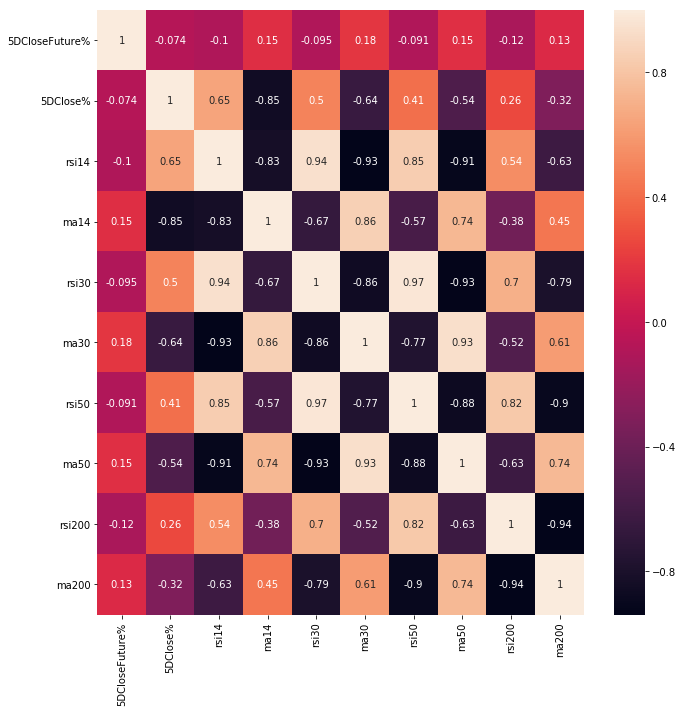

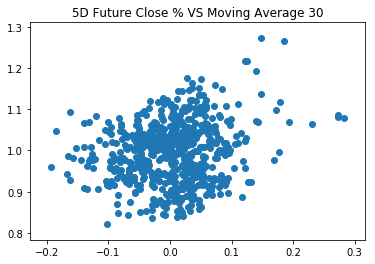

In [57]:
# Preparing the Features and Target data sets

# Lets drop the NA values which will mess up with ML model otherwise
data=data.dropna()

# Declare target and features
target=data['5DCloseFuture%']
features=data[features_names]

#Features_Target_Data
Features_Target_Data=data[['5DCloseFuture%']+features_names]

# Find the correlation between targets and features
print("Correlation Between Features And Targets")
Corr=Features_Target_Data.corr()
# print(Corr)

# Plotting the correlation
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(Corr,annot=True,ax=ax)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area


# The most Correlated feature is ma30, so lets do a scatter plot with respect to 5DFutureClose%
plt.scatter(data['5DCloseFuture%'],data['ma30'])
plt.title("5D Future Close % VS Moving Average 30")
plt.show()

## 4) Fitting the model, Machine Learning : Linear Regression

In [58]:
import statsmodels.api as sm

# Adding Constant
linear_features=sm.add_constant(features)

# Splitting data into test and train set
train_size=int(0.85*features.shape[0])

train_features=features[:train_size]
train_targets=target[:train_size]
test_features=features[train_size:]
test_targets=target[train_size:]


model=sm.OLS(train_targets,train_features)
results=model.fit()
print(results.summary())
print(results.pvalues)

train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)


                            OLS Regression Results                            
Dep. Variable:         5DCloseFuture%   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     10.64
Date:                Wed, 22 May 2019   Prob (F-statistic):           3.05e-15
Time:                        08:11:54   Log-Likelihood:                 769.12
No. Observations:                 540   AIC:                            -1520.
Df Residuals:                     531   BIC:                            -1482.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
5DClose%      -0.0254      0.079     -0.322      0.7

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


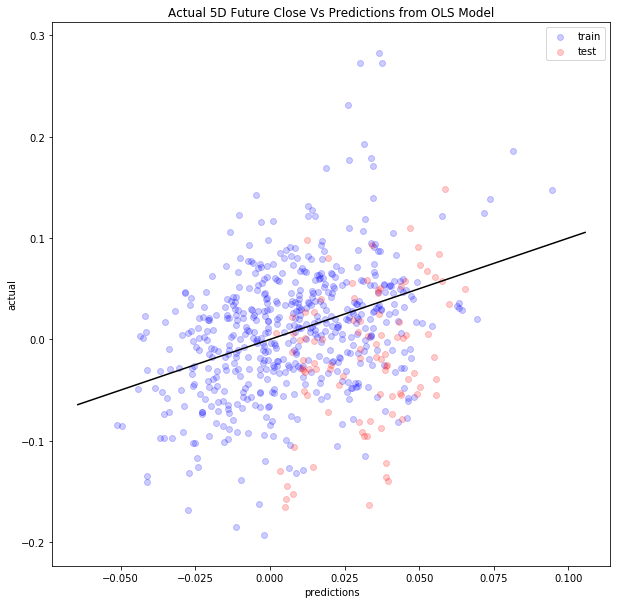

In [59]:
plt.figure(figsize=(10,10))
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions,test_targets,alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.title("Actual 5D Future Close Vs Predictions from OLS Model")
plt.legend()  # show the legend
plt.show()

## 5) Adding More Features for ML & Feature Engineering <br>
1) Volumne <br>
2) Day of Week

If you are going to just use Linear model you need to build interactive features. Like 2 features 30RSI and 45MA must be multiplied to get a new features. However we don't need such engineer if we are going to use Random Forest & Gradient Boosting. In such models features interact with each other themsevles to give a better outcome

### Adding Volumne as a feature

In [60]:
new_features=['Volume_1D_Change','Volume_1D_Change_SMA']
features_names.extend(new_features)
data['Volume_1D_Change']=data['Volume'].pct_change()
data['Volume_1D_Change_SMA']=talib.SMA(data['Volume_1D_Change'],timeperiod=5)

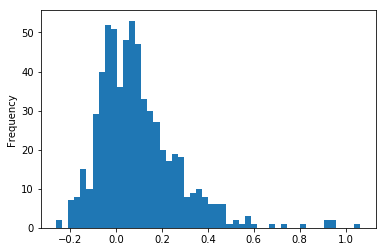

In [61]:
data['Volume_1D_Change_SMA'].plot(kind='hist',sharex=False, bins=50)
plt.show()

### Adding Days Of Weeks as features


In [62]:
days_of_weeks= pd.get_dummies(data.index.dayofweek,prefix='weekday',drop_first=True)
days_of_weeks.index=data.index

data=pd.concat([data,days_of_weeks],axis=1)

features_names.extend(['weekday_' + str(i) for i in range(1, 5)])
data=data.dropna()
print(data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-10-25  202.899994  204.690002  201.199997  202.339996  202.339996   
2016-10-26  201.000000  203.190002  200.100006  202.240005  202.240005   
2016-10-27  211.339996  213.699997  201.649994  204.009995  204.009995   
2016-10-28  204.000000  205.320007  199.830002  199.970001  199.970001   
2016-10-31  202.490005  202.490005  195.809998  197.729996  197.729996   

              Volume  5DayFutureClose  5DCloseFuture%  5DClose%      ma14  \
Date                                                                        
2016-10-25   2445000       190.789993       -0.057082  0.016273  0.987669   
2016-10-26   5632800       188.020004       -0.070313 -0.006485  0.988596   
2016-10-27  13093700       187.419998       -0.081320  0.024661  0.982609   
2016-10-28   4280100       190.559998       -0.047057 -0.000600  1.002111   
2016-10-31   469230

### Correlation graphs for new Features, Volume Change & Weekdays

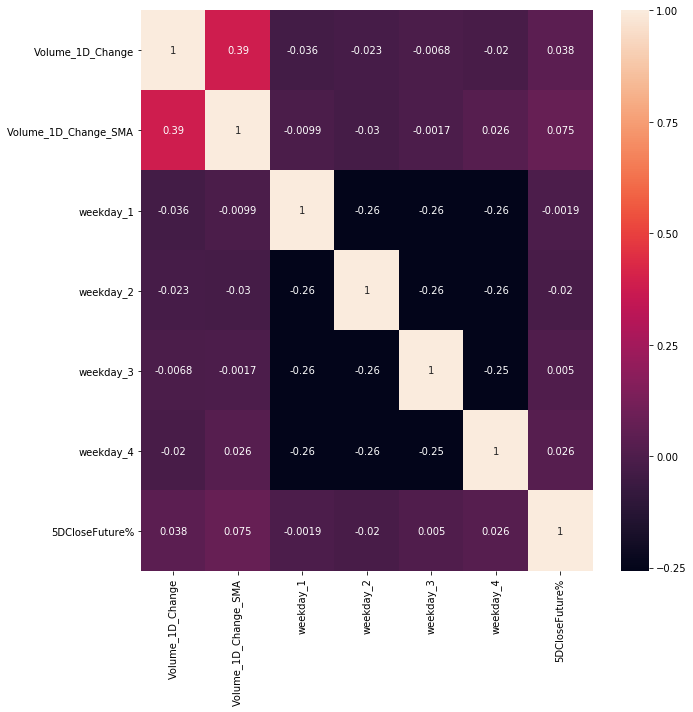

In [63]:
new_features.extend(['weekday_'+str(i) for i in range(1,5)])

# Plot the correlations between the new features and the targets
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data[new_features + ['5DCloseFuture%']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()


## 6) ML Continues : Decision Tree

In [64]:
from sklearn.tree import DecisionTreeRegressor

model=DecisionTreeRegressor()

model.fit(train_features, train_targets)

print(model.score(train_features,train_targets))
print(model.score(test_features,test_targets))

0.9999992148656507
-1.9086265177958888


It's a perfect fit on the training data, but not so good on the test data, our model certaily can perform better and certainly needs some optimization. Lets add depth to the Tree

In [65]:
for n in [2,3,5,10,15]:
    model=DecisionTreeRegressor(max_depth=n)
    model.fit(train_features,train_targets)
    print("Max Depth:"+ str(n))
    print(model.score(train_features,train_targets))
    print(model.score(test_features,test_targets))

Max Depth:2
0.11275026562161405
-0.4992138347171324
Max Depth:3
0.2127471762105757
-0.7598820803811832
Max Depth:5
0.3627647600961562
-1.155993810616879
Max Depth:10
0.7678511761189145
-1.843534214182428
Max Depth:15
0.9551822406756244
-1.321336746545954


A max_depth of 3 seems to work very good, so lets plit it, obviously if we increase the number of max trees it will fit very good on the training data and worse on the test data. We will explore more options in future to test more parameters to get higher accuracy in fitting these models

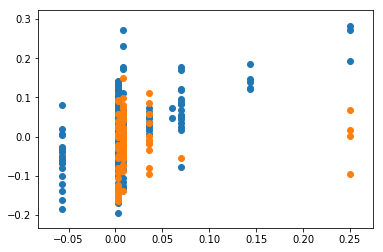

-0.7598820803811832


In [66]:
decision_tree=DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features,train_targets)

train_pred=decision_tree.predict(train_features)
test_pred=decision_tree.predict(test_features)

plt.scatter(train_pred, train_targets,label='test')
plt.scatter(test_pred, test_targets,label='test')
plt.show()

print(decision_tree.score(test_features, test_targets))

Because of limited depth the predictions are in lines 

## 7) Machine Leaning : Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9101879760922877
-0.13862494887641885


### Tune Hyperparameters

In [68]:
from sklearn.model_selection import ParameterGrid

target=data['5DCloseFuture%']
features=data[features_names]

train_features=features[:train_size]
train_targets=target[:train_size]
test_features=features[train_size:]
test_targets=target[train_size:]
              
grid={'n_estimators':[200],'max_depth':[3],'max_features':[4,8],'random_state':[42]}
test_score=[]

for g in ParameterGrid(grid):
    rfr.set_params(**g)
    rfr.fit(train_features, train_targets)
    test_score.append(rfr.score(test_features, test_targets))
    
best_idx=np.argmax(test_score)    
print(test_score[best_idx],ParameterGrid(grid)[best_idx])


-0.03924997052541723 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


### Getting Important Features

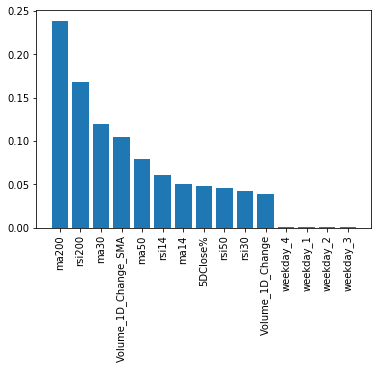

In [69]:

importances=rfr.feature_importances_
sorted_index=np.argsort(importances)[::-1]
x=range(len(importances))

labels=np.array(features_names)[sorted_index]
plt.bar(x,importances[sorted_index],tick_label=labels)

plt.xticks(rotation=90)
plt.show()

### Gradient Boosting 

GB is similar to Random Forest with difference that trees are built successively. With iteration the next tree fits the residual errors from the previous tree in order to improve the fit 

from sklearn.ensemble import GradientBoostingRegressor 

gbr=GradientBoostingRegressor(max_features=4,learning_rate=0.01,n_estimators=200,subsample=0.6, random_state=42)

gbr.fit(train_features,train_targets)

print(gbr.score(train_features,train_targets))
print(gbr.score(test_features,test_targets))

print("The result is not that better from Random Forest but we are getting there")

## 7) Machine Leaning : Neural Networks & KNN for predicting future stock values 

Both methods work better with standardised data. We know from the "Getting Importance Features" that the Weekday data has very low importance, so we remove them. 

In [70]:
train_features=train_features.iloc[:,:-4]
test_features=test_features.iloc[:,:-4]

### Scaling the data

Scaling the data


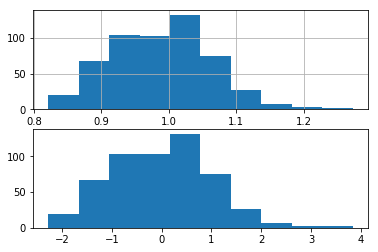

In [71]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features=scale(train_features)
scaled_test_features=scale(test_features)


print("Scaling the data")

f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 4].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 4])
plt.show()



In [72]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,12):
    knn=KNeighborsRegressor(n_neighbors=n)
    knn.fit(scaled_train_features, train_targets)
    
    print("Neighbors="+str(n))
    print("test train score")
    print(knn.score(scaled_train_features,train_targets))
    print(knn.score(scaled_test_features,test_targets))
    print()


Neighbors=2
test train score
0.7270052764149609
-0.6221658783781898

Neighbors=3
test train score
0.5679063182128087
-0.3683860384742264

Neighbors=4
test train score
0.48251291389844214
-0.20353959544616096

Neighbors=5
test train score
0.40158373327956465
-0.10768209390026941

Neighbors=6
test train score
0.3453160351648634
-0.11206758593300603

Neighbors=7
test train score
0.3205925147829858
-0.05304768614808997

Neighbors=8
test train score
0.2998532043413127
-0.12503307967749833

Neighbors=9
test train score
0.27342452563721553
-0.11943867425595857

Neighbors=10
test train score
0.2634742135722036
-0.12073607719159839

Neighbors=11
test train score
0.23859457140504203
-0.1009275161404779



In this case n=7 gives the best case scenario and hence we can evaluate performance of n=7

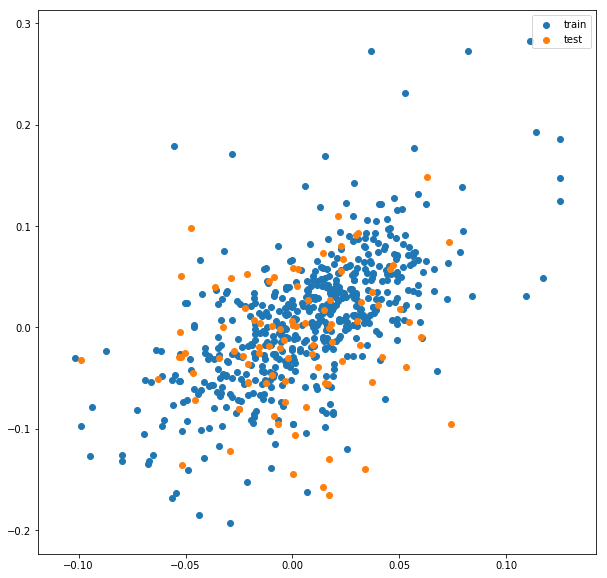

In [73]:
knn=KNeighborsRegressor(5)

knn.fit(scaled_train_features,train_targets)

train_predictions=knn.predict(scaled_train_features)
test_predictions=knn.predict(scaled_test_features)

fig, ax = plt.subplots(figsize=(10,10)) 
plt.scatter(train_predictions,train_targets,label='train')
plt.scatter(test_predictions,test_targets,label='test')
plt.legend()
plt.show()


### Neural Networks

In [74]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
540/540 [==============================] - 0s 744us/step - loss: 0.0392
Epoch 2/25
540/540 [==============================] - 0s 63us/step - loss: 0.0115
Epoch 3/25
540/540 [==============================] - 0s 62us/step - loss: 0.0066
Epoch 4/25
540/540 [==============================] - 0s 64us/step - loss: 0.0052
Epoch 5/25
540/540 [==============================] - 0s 63us/step - loss: 0.0044
Epoch 6/25
540/540 [==============================] - 0s 68us/step - loss: 0.0040
Epoch 7/25
540/540 [==============================] - 0s 85us/step - loss: 0.0036
Epoch 8/25
540/540 [==============================] - 0s 78us/step - loss: 0.0034
Epoch 9/25
540/540 [==============================] - 0s 86us/step - loss: 0.0032
Epoch 10/25
540/540 [==============================] - 0s 84us/step - loss: 0.0031
Epoch 11/25
540/540 [==============================] - 0s 77us/step - loss: 0.0031
Epoch 12/25
540/540 [==============================] - 0s 84us/step - loss: 0.0030
Epoch 13/25


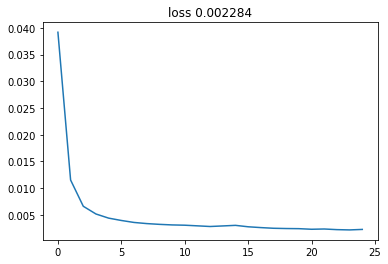

Our Loss keeps falling which is good


In [75]:
plt.plot(history.history['loss'])

plt.title('loss '+str(round(history.history['loss'][-1],6)))
plt.show()

print("Our Loss keeps falling which is good")

### Plotting the perfomance

-0.32460170755329965
-2.405816423430472


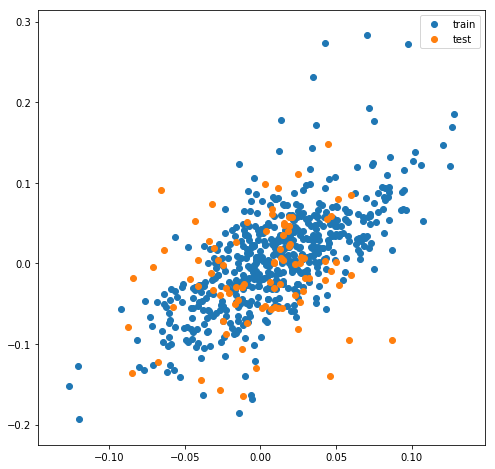

In [76]:
from sklearn.metrics import r2_score
train_pred=model_1.predict(scaled_train_features)
test_pred=model_1.predict(scaled_test_features)

print(r2_score(train_pred,train_targets))
print(r2_score(test_pred,test_targets))

fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(train_pred, train_targets,label='train')
plt.scatter(test_pred, test_targets,label='test')
plt.legend()
plt.show()

### Building a custom loss function

In [77]:
import keras.losses
import tensorflow as tf

def sign_penalty(y_true,y_pred):
    penalty=100
    loss=tf.where(tf.less(y_true*y_pred,0), \
                 penalty * tf.square(y_true-y_pred), \
                 tf.square(y_true - y_pred))
    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x1c2c4c7378>


Epoch 1/25
540/540 [==============================] - 0s 826us/step - loss: 3.6505
Epoch 2/25
540/540 [==============================] - 0s 66us/step - loss: 0.9140
Epoch 3/25
540/540 [==============================] - 0s 65us/step - loss: 0.6337
Epoch 4/25
540/540 [==============================] - 0s 67us/step - loss: 0.4699
Epoch 5/25
540/540 [==============================] - 0s 62us/step - loss: 0.3789
Epoch 6/25
540/540 [==============================] - 0s 63us/step - loss: 0.3037
Epoch 7/25
540/540 [==============================] - 0s 64us/step - loss: 0.2572
Epoch 8/25
540/540 [==============================] - 0s 63us/step - loss: 0.2227
Epoch 9/25
540/540 [==============================] - 0s 63us/step - loss: 0.2058
Epoch 10/25
540/540 [==============================] - 0s 76us/step - loss: 0.1786
Epoch 11/25
540/540 [==============================] - 0s 87us/step - loss: 0.1820
Epoch 12/25
540/540 [==============================] - 0s 96us/step - loss: 0.1664
Epoch 13/25


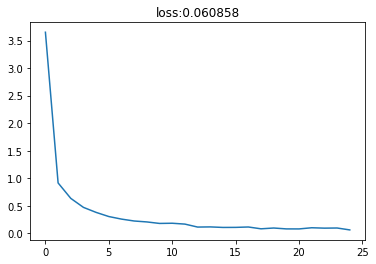

0.23871508944428566
-0.6037479553479661


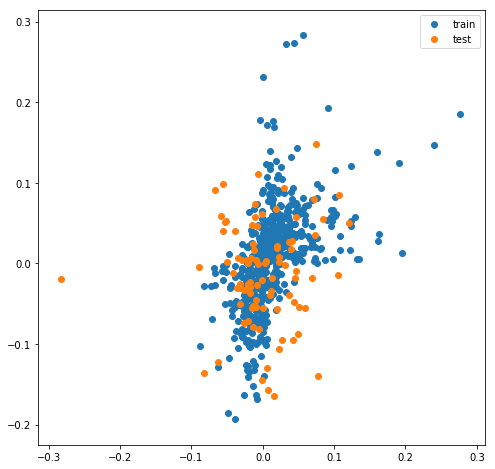

In [78]:
model_2=Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1],activation='relu'))
model_2.add(Dense(20,activation='relu'))
model_2.add(Dense(1,activation='linear'))

model_2.compile(optimizer='adam',loss='sign_penalty')
history=model_2.fit(scaled_train_features,train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

train_preds=model_2.predict(scaled_train_features)
test_preds=model_2.predict(scaled_test_features)

print(r2_score(train_targets,train_preds))
print(r2_score(test_targets,test_preds))

fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets,label='test')  # plot test set
plt.legend(); plt.show()

### Overfitting and Ensemble

Epoch 1/25
540/540 [==============================] - 1s 960us/step - loss: 0.0338
Epoch 2/25
540/540 [==============================] - 0s 72us/step - loss: 0.0153
Epoch 3/25
540/540 [==============================] - 0s 84us/step - loss: 0.0119
Epoch 4/25
540/540 [==============================] - 0s 76us/step - loss: 0.0107
Epoch 5/25
540/540 [==============================] - 0s 75us/step - loss: 0.0072
Epoch 6/25
540/540 [==============================] - 0s 73us/step - loss: 0.0072
Epoch 7/25
540/540 [==============================] - 0s 83us/step - loss: 0.0054
Epoch 8/25
540/540 [==============================] - 0s 95us/step - loss: 0.0055
Epoch 9/25
540/540 [==============================] - 0s 88us/step - loss: 0.0055
Epoch 10/25
540/540 [==============================] - 0s 87us/step - loss: 0.0047
Epoch 11/25
540/540 [==============================] - 0s 83us/step - loss: 0.0049
Epoch 12/25
540/540 [==============================] - 0s 85us/step - loss: 0.0051
Epoch 13/25


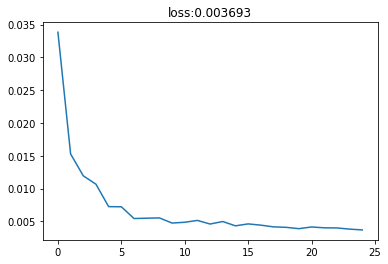

In [81]:
from keras.layers import Dropout

model_3=Sequential()
model_3.add(Dense(100,input_dim=scaled_train_features.shape[1],activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20,activation='relu'))
model_3.add(Dense(1,activation='linear'))

model_3.compile(optimizer='adam',loss='mse')
history=model_3.fit(scaled_train_features,train_targets,epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

### Ensembling the Model 1, Model 2, Model 3 

[0.0318043  0.06187753 0.07438537 0.03589416 0.04497865]
0.3992141135169863
-0.0526730191887288


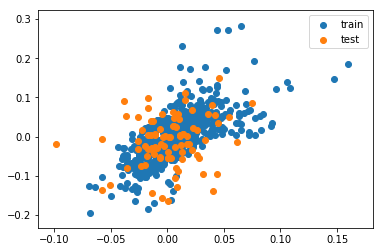

In [84]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1,test_pred2,test_pred3)), axis=1)
print(test_preds[-5:])

# Checking the performance of the Ensembled model we just built

print(r2_score(train_targets,train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds,train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()